## Pf6 within-host nucleotide diversity

This code examines the frequency distribution of within-host nucleotide diversity $\pi_W$ in the [Pf6 dataset](https://www.malariagen.net/sites/default/files/File8_Pf_6_README_20191010_0.txt).  If you scroll to the bottom of this page you will see that $\pi_W$ has a strikingly bimodal distribution.  We postulate that one of the peaks (with high $\pi_W$) represents hosts that have been superinfected, or who lie on a transmission chain where there is cotransmission following a recent episode of superinfection.  We postulate that the other peak (with low $\pi_w$) represents transmission chains where there has been no recent superinfection of cotransmission.  We can use the latter peak to estimate the quantum of transmission with the formula $Q = \pi_W / 2 \mu$.

#### Prior to this notebook

* Zarr data and sample metadata were downloaded to  ThinkPad_2022 in 'C:\\Users\\dkwia\\Data\\Pf6\\'. 

* Following steps were performed using \Github\gtg\Pf6_het_calls_230317.ipynb

* extract lists of samples (n = 7,113) and variant properties (n = 6,051,696) as arrays

* select variants that are high-quality biallelic coding SNPs (n = 502,221). High quality means 'filter_pass == True' & 'vqslod > 3'

* extract allele depth for high-quality SNPs from Zarr into `allele_depth_1.npy`.  We do this in chunks of 10,000 variants at a time to avoid memory problems

* extract sample metadata from samples.txt into a dataframe, then read info about sample QC into an array

* select samples that passed QC (n = 5,970) and record their geographic region in a list called 'region'. 

* extract allele depth for high-quality SNPs and high-quality samples (n = 5,970) into `allele_depth_2.npy` 

* calculate within-host heterozygosity for each SNP in each sample and save to `wiho_het.npy`

* calculate mean within-host heterozygosity for each SNP across all samples and save to a list called 'wiho_het_per_snp'

#### In this notebook

* using wiho_het_per_snp, create `snp_filter` to filter out potential hyperhet SNPs

* create `sample_filter` to select samples from a particular geographical region

* calculate $\pi_W$ for each sample, using mean within-host heterozygosity per sample, and allowing for the number of SNPs ascertained and the size of coding regions

* plot a histogram of nucleotide diversity per sample

* view the histogram for different filter cutoffs for hyperhet SNPs and for different regions e.g. West Africa vs Southeast Asia

#### We will use these files

`230113_wiho_het.npy`
* Gives within-host heterozygosity for each SNP (n = 502,221) and each sample (n = 5,970).  
* As we have selected biallelic SNPs this is easy to calculate.  If ref_allele + alt_allele == 0 then we write het = 0.
* This file is 23.5GB because dtype=float

`230316_region`
* A list of geographical regions for 5,970 selected samples
* 'SAM'=South America, 'WAF'=West Africa, 'CAF'=Central Africa, 'EAF'=East African, 'SAS'=South Asia, 'WSEA'=Western SE Asia, 'ESEA'=Eastern SE Asia, 'OCE'=Oceania

`230317_het_per_snp`
* Mean within-host heterozygosity for each SNP, calculated from wiho_het.npy

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
data_path = "/content/drive/My Drive/Colab Data/Pf6/"

!ls "/content/drive/My Drive/Colab Data/Pf6/"

230113_wiho_het.npy	    230316_region
230316_het_per_sample_ESEA  230317_het_per_sample_ALL
230316_het_per_sample_SEA   230317_het_per_sample_CAF_EAF
230316_het_per_sample_WAF   230317_het_per_snp


In [4]:
import numpy as np
import json
import math
import matplotlib.pyplot as plt
import statistics as stat

In [5]:
selected_snps = 502221
selected_samples = 5970

#### Create `snp_filter` to filter out possible hyperhets
* Here we use het >= 0.02 as our criterion for exclusion 

In [6]:
with open(data_path + "230317_het_per_snp", "r") as fp:
    het_per_snp = json.load(fp)

snp_filter = []

for i in range(selected_snps):
    
    if het_per_snp[i] < 0.02:
        
        snp_filter.append(True)
    
    else:
        snp_filter.append(False)
        
filtered_snps = snp_filter.count(True)
        
print('This includes', str(filtered_snps), 'SNPs')

This includes 496459 SNPs


#### Create `sample_filter` to select a particular geographical region
* 'SAM'=South America, 'WAF'=West Africa, 'CAF'=Central Africa, 'EAF'=East African, 'SAS'=South Asia, 'WSEA'=Western SE Asia, 'ESEA'=Eastern SE Asia, 'OCE'=Oceania

In [13]:
with open(data_path + "230316_region", "r") as fp:
    region = json.load(fp)

sample_filter = []

for i in range(selected_samples):
    
    if region[i] == "CAF" or region[i] == "EAF" or region[i] == "WAF":
        
        sample_filter.append(True)
        
    else:
        
        sample_filter.append(False)
        
filtered_samples = sample_filter.count(True)
    
print('This includes', str(filtered_samples), 'samples')

This includes 3314 samples


#### Calculate mean heterozygosity per sample after filtering samples and SNPs
* Creates a list of het values, one for each selected & filtered sample 
* This is the mean het for selected & filtered SNPs and not for all nucleotide positions
* With GPU this takes approximately 15 minutes depending on the selection of regions
* Save the output for future use

In [ ]:
wiho_het = np.load(data_path + '230113_wiho_het.npy', mmap_mode = 'r')

het_per_sample = []

for i in range(selected_samples):
    
    if sample_filter[i] == True:

        het = []
    
        for j in range(selected_snps):
    
            if snp_filter[j] == True: 
            
                het.append(wiho_het[j, i])
    
        y = stat.mean(het)
    
        het_per_sample.append(y)
    
    if i % 10 == 0:
        
        print(i)
        
with open(data_path + "230317_het_per_sample_Africa", "w") as filepath:
    json.dump(het_per_sample, filepath)

#### Plot histogram of within-host nucleotide diversity

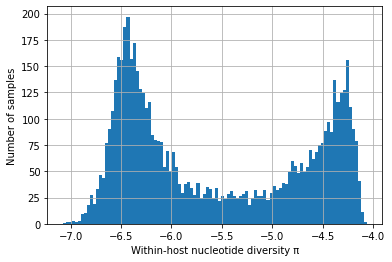

In [20]:
# All regions - only SNPs with maf < 0.01

with open(data_path + "230317_het_per_sample_ALL", "r") as filepath:
    het_per_sample = json.load(filepath)
    
selected_snps = 494829 # this is <0.01 maf, total is 502221
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = selected_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

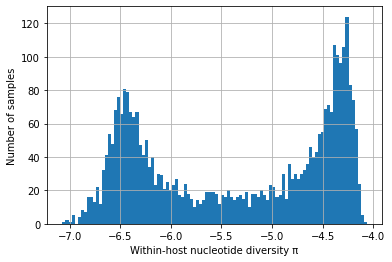

In [16]:
# Africa - only SNPs with maf < 0.01

with open(data_path + "230317_het_per_sample_Africa", "r") as filepath:
    het_per_sample = json.load(filepath)
    
selected_snps = 494829 # this is <0.01 maf, total is 502221
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = selected_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

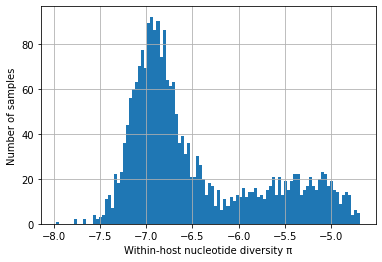

In [21]:
# Southeast Asia - only SNPs with maf < 0.01 

with open(data_path + "230316_het_per_sample_SEA", "r") as filepath:
    het_per_sample = json.load(filepath)
    
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = filtered_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

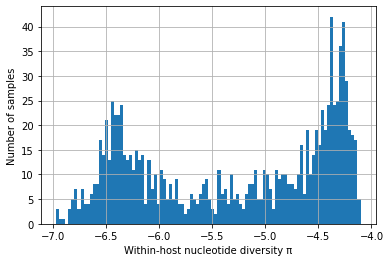

In [12]:
# Central and East Africa - only SNPs with maf < 0.01

with open(data_path + "230317_het_per_sample_CAF_EAF", "r") as filepath:
    het_per_sample = json.load(filepath)
    
selected_snps = 494829 # this is <0.01 maf, total is 502221
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = selected_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

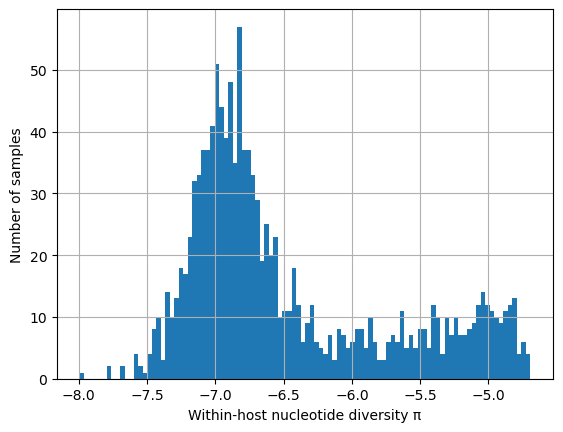

In [ ]:
# Eastern Southeast Asia - only SNPs with maf < 0.01 

with open(data_path + "230316_het_per_sample_ESEA", "r") as filepath:
    het_per_sample = json.load(filepath)
    
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = filtered_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

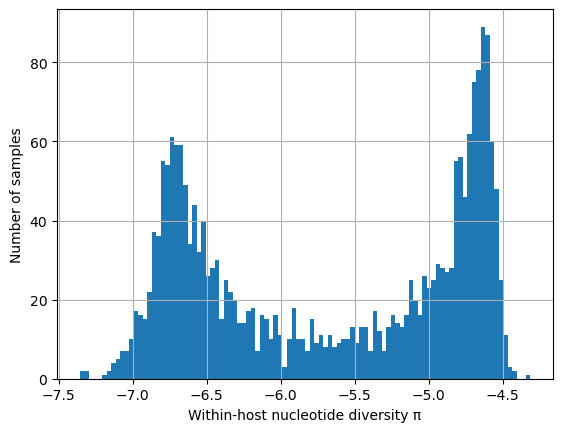

In [ ]:
# West Africa - only SNPs with maf < 0.01 

with open(data_path + "230316_het_per_sample_WAF", "r") as filepath:
    het_per_sample = json.load(filepath)
    
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = filtered_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()